In [1]:
# Import required modules
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib as plt

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [11]:
%matplotlib inline

To do:
* get continious and categorical variable names -**done**
* Convert categorical with to binary -**done**
* merge converted data with continious
* run regression model

## Data Understanding

Data is Allstate data blah. A predictive model will allow insight into things. more blah.

In [2]:
#import training data set
train = pd.read_csv("../data/raw/train.csv.zip", compression="zip", index_col='id')

In [3]:
# Gather metadata
def get_metadata(df):
    names = []
    unique_cats = []
    missing_vals = []
    val_dtype = []
    for c in df.columns:
        names = np.append(names, c)
        unique_cats = np.append(unique_cats, (len(df[c].unique())))
        missing_vals = np.append(missing_vals, df[c].isnull().sum())
        val_dtype = np.append(val_dtype, df[c].dtype)

    meta_data = pd.DataFrame({'Variable':names, 
                              'Unique':unique_cats.astype(int), 
                              'Num Missing':missing_vals.astype(int),
                              'Data Type':val_dtype
                             })
    return meta_data

meta_data = get_metadata(train)
meta_data.to_csv("../data/interim/training_metadata.csv", index=False)

In [4]:
#Data Type	Num Missing	Unique	Variable
response_name = 'loss'
cat_names = meta_data[meta_data['Data Type']=='object']['Variable']
cont_names = meta_data[(meta_data['Data Type']=='float64') & 
                       (meta_data['Variable']!='loss')]['Variable']

print("There are %.f categorical variables." % len(cat_names))
print("There are %.f continuous variables." % len(cont_names))

print("%.f categorical variables are binary." % len(meta_data[(meta_data['Data Type']=='object') & 
                                                              (meta_data['Unique'] == 2)]['Variable']))

print("%.f categorical variables have high cardinality with more than 50." % \
      len(meta_data[(meta_data['Data Type']=='object') & (meta_data['Unique'] > 50)]['Variable']))

There are 116 categorical variables.
There are 14 continuous variables.
72 categorical variables are binary.
5 categorical variables have high cardinality with more than 50.


#### Pandas-profiling module creates a report to identify variable characteristics. This is output as a separate html file for cleaner consumption. located in the report folder of this project

Characteristics identified:
* Continueous variables 'cont11' and 'cont12' are highly correlated with r=.99 (Chart below). Will exclude one.
* Continueous variables 'cont1' and 'cont9' are highly correlated with r=.93 (Chart below). Will exclude one.

In [5]:
train_profile = pandas_profiling.ProfileReport(train)
rejected_variables = train_profile.get_rejected_variables(threshold=0.9)
train_profile.to_file(outputfile="../reports/myoutputfile.html")

## Shape of Variable of Interese 'loss'

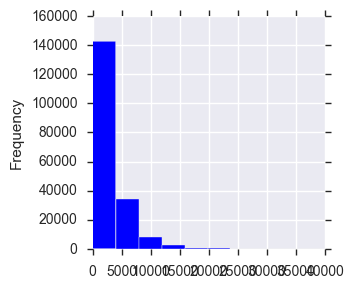

In [12]:
train[train['loss']<40000]['loss'].plot.hist(by=train[train['loss']<40000]['cat1'], figsize=(3, 3))

---
### cont11 and cont12 are highly correlated - may drop cont12

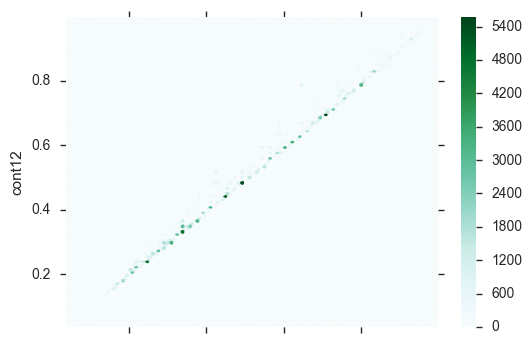

In [13]:
train.plot.hexbin(x='cont11', y='cont12')

---
### 'cont1' and 'cont9' are highly correlated as well at r=.93. There might be some outliers in cont9 where cont1 is 0, however, they appear to be relatively small proportion.  I will keep in dataset

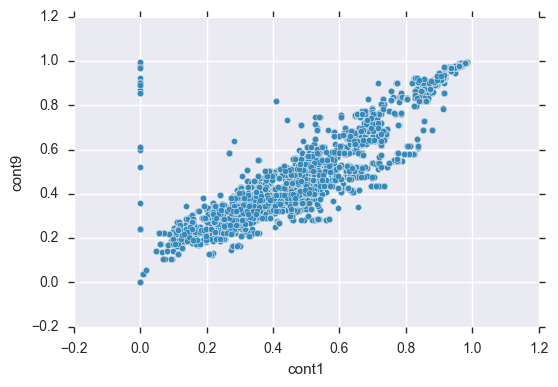

In [8]:
train.plot.scatter(x='cont1', y='cont9')

## Data Prep

In [9]:
import category_encoders as ce
encoder = ce.BinaryEncoder()

categorical_data = encoder.fit_transform(train[cat_names])

C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\category_encoders\ordinal.py:190: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  X[col] = X[col].astype(int).reshape(-1, )
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\category_encoders\ordinal.py:179: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  X[switch.get('col')] = X[switch.get('col')].astype(int).reshape(-1, )


In [10]:
# Merge transformed categorical data with continuous
cont_names_to_drop =['cont12' # highly correlated to cont11
                     ,'cont9' # highly correlated to cont1
                    ]
cont_names_final = cont_names[~cont_names.isin(cont_names_to_drop)]

train_final1 = pd.concat([train[cont_names], categorical_data], axis=1)